# What changes
- Changed learning rate to 0.0003
- Decreased batch size to 16
- Increased patience of early stopping to 15 epochs

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# We discovered that unzipping the dataset inside colab help to reduce the time required to train the first epochs

%cd /content

/content


In [ ]:
!unzip ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/only_tomato.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: only_tomato/train/Tomato/42653.jpg  
  inflating: only_tomato/train/Tomato/38640.jpg  
  inflating: only_tomato/train/Tomato/39219.jpg  
  inflating: only_tomato/train/Tomato/41120.jpg  
  inflating: only_tomato/train/Tomato/41564.jpg  
  inflating: only_tomato/train/Tomato/40160.jpg  
  inflating: only_tomato/train/Tomato/42811.jpg  
  inflating: only_tomato/train/Tomato/40907.jpg  
  inflating: only_tomato/train/Tomato/39684.jpg  
  inflating: only_tomato/train/Tomato/43993.jpg  
  inflating: only_tomato/train/Tomato/42089.jpg  
  inflating: only_tomato/train/Tomato/38356.jpg  
  inflating: only_tomato/train/Tomato/21344.jpg  
  inflating: only_tomato/train/Tomato/38164.jpg  
  inflating: only_tomato/train/Tomato/43943.jpg  
  inflating: only_tomato/train/Tomato/38513.jpg  
  inflating: only_tomato/train/Tomato/39466.jpg  
  inflating: only_tomato/train/Tomato/43731.jpg  
  inflating: only_tomato/train/Tomato/21439.jpg  


#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'only_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

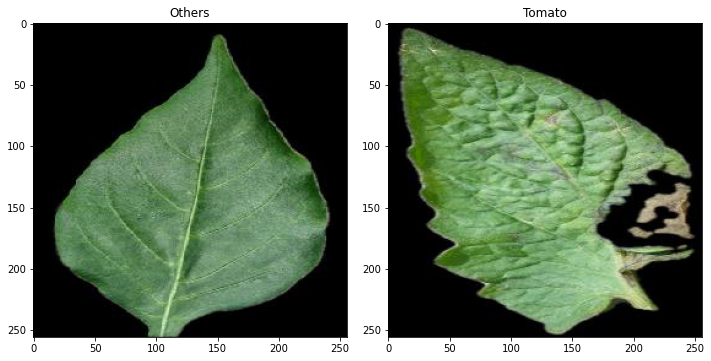

In [ ]:
# Plot example images from dataset
labels = ['Others','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))


plt.tight_layout()
plt.show()

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Create an instance of ImageDataGenerator with Data Augmentation like the previous one, same parameters
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', rescale=1/255.)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)


Found 13295 images belonging to 2 classes.
Found 2658 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model used:
# Same network  as the version 1
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0003), metrics='accuracy')

    # Return the model
    return model

#Building Model

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check') # this is the directory in which will be saved all checkpoints of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='v2_DA_only_tomato')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [noaug_callbacks],
).history

Epoch 1/200
831/831 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.7493

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 173s 189ms/step - loss: 0.5213 - accuracy: 0.7493 - val_loss: 0.4286 - val_accuracy: 0.8040
Epoch 2/200
831/831 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8389

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 188ms/step - loss: 0.3747 - accuracy: 0.8389 - val_loss: 0.3796 - val_accuracy: 0.8536
Epoch 3/200
831/831 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8656

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 193ms/step - loss: 0.3291 - accuracy: 0.8656 - val_loss: 0.2630 - val_accuracy: 0.8939
Epoch 4/200
831/831 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.8894

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 187ms/step - loss: 0.2745 - accuracy: 0.8894 - val_loss: 0.2881 - val_accuracy: 0.8837
Epoch 5/200
831/831 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9008

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 187ms/step - loss: 0.2494 - accuracy: 0.9008 - val_loss: 0.2257 - val_accuracy: 0.9123
Epoch 6/200
831/831 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9134

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 165s 199ms/step - loss: 0.2270 - accuracy: 0.9134 - val_loss: 0.1734 - val_accuracy: 0.9334
Epoch 7/200
831/831 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9173

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 188ms/step - loss: 0.2086 - accuracy: 0.9173 - val_loss: 0.1470 - val_accuracy: 0.9432
Epoch 8/200
831/831 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9179

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 163s 197ms/step - loss: 0.2079 - accuracy: 0.9179 - val_loss: 0.1480 - val_accuracy: 0.9432
Epoch 9/200
831/831 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9211

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 162s 195ms/step - loss: 0.2017 - accuracy: 0.9211 - val_loss: 0.1345 - val_accuracy: 0.9481
Epoch 10/200
831/831 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9282

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1856 - accuracy: 0.9282 - val_loss: 0.1274 - val_accuracy: 0.9530
Epoch 11/200
831/831 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9321

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 194ms/step - loss: 0.1767 - accuracy: 0.9321 - val_loss: 0.1097 - val_accuracy: 0.9597
Epoch 12/200
831/831 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9329

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1744 - accuracy: 0.9329 - val_loss: 0.1336 - val_accuracy: 0.9533
Epoch 13/200
831/831 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9339

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1711 - accuracy: 0.9339 - val_loss: 0.1008 - val_accuracy: 0.9601
Epoch 14/200
831/831 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9349

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 194ms/step - loss: 0.1669 - accuracy: 0.9349 - val_loss: 0.1459 - val_accuracy: 0.9481
Epoch 15/200
831/831 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9372

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 194ms/step - loss: 0.1612 - accuracy: 0.9372 - val_loss: 0.1497 - val_accuracy: 0.9417
Epoch 16/200
831/831 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9409

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 194ms/step - loss: 0.1570 - accuracy: 0.9409 - val_loss: 0.1116 - val_accuracy: 0.9571
Epoch 17/200
831/831 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9395

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 193ms/step - loss: 0.1518 - accuracy: 0.9395 - val_loss: 0.0995 - val_accuracy: 0.9646
Epoch 18/200
831/831 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9398

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 158s 190ms/step - loss: 0.1555 - accuracy: 0.9398 - val_loss: 0.1079 - val_accuracy: 0.9590
Epoch 19/200
831/831 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9463

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 158s 190ms/step - loss: 0.1449 - accuracy: 0.9463 - val_loss: 0.1305 - val_accuracy: 0.9556
Epoch 20/200
831/831 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9410

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1478 - accuracy: 0.9410 - val_loss: 0.0864 - val_accuracy: 0.9669
Epoch 21/200
831/831 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9440

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 188ms/step - loss: 0.1414 - accuracy: 0.9440 - val_loss: 0.0969 - val_accuracy: 0.9669
Epoch 22/200
831/831 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9474

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1364 - accuracy: 0.9474 - val_loss: 0.1482 - val_accuracy: 0.9406
Epoch 23/200
831/831 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9492

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 188ms/step - loss: 0.1353 - accuracy: 0.9492 - val_loss: 0.1057 - val_accuracy: 0.9620
Epoch 24/200
831/831 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9481

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 188ms/step - loss: 0.1345 - accuracy: 0.9481 - val_loss: 0.1210 - val_accuracy: 0.9511
Epoch 25/200
831/831 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9470

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 187ms/step - loss: 0.1313 - accuracy: 0.9470 - val_loss: 0.1114 - val_accuracy: 0.9575
Epoch 26/200
831/831 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9460

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 155s 187ms/step - loss: 0.1351 - accuracy: 0.9460 - val_loss: 0.0832 - val_accuracy: 0.9714
Epoch 27/200
831/831 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9476

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 162s 195ms/step - loss: 0.1316 - accuracy: 0.9476 - val_loss: 0.0984 - val_accuracy: 0.9646
Epoch 28/200
831/831 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9549

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 163s 196ms/step - loss: 0.1205 - accuracy: 0.9549 - val_loss: 0.0865 - val_accuracy: 0.9691
Epoch 29/200
831/831 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9523

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 162s 195ms/step - loss: 0.1243 - accuracy: 0.9523 - val_loss: 0.1155 - val_accuracy: 0.9545
Epoch 30/200
831/831 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9505

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 162s 195ms/step - loss: 0.1258 - accuracy: 0.9505 - val_loss: 0.1781 - val_accuracy: 0.9391
Epoch 31/200
831/831 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9547

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 193ms/step - loss: 0.1215 - accuracy: 0.9547 - val_loss: 0.0874 - val_accuracy: 0.9661
Epoch 32/200
831/831 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9525

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 193ms/step - loss: 0.1236 - accuracy: 0.9525 - val_loss: 0.0706 - val_accuracy: 0.9755
Epoch 33/200
831/831 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9535

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 155s 187ms/step - loss: 0.1213 - accuracy: 0.9535 - val_loss: 0.1402 - val_accuracy: 0.9500
Epoch 34/200
831/831 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9545

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 155s 187ms/step - loss: 0.1197 - accuracy: 0.9545 - val_loss: 0.0854 - val_accuracy: 0.9695
Epoch 35/200
831/831 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9537

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 155s 187ms/step - loss: 0.1216 - accuracy: 0.9537 - val_loss: 0.0797 - val_accuracy: 0.9729
Epoch 36/200
831/831 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9520

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 156s 187ms/step - loss: 0.1225 - accuracy: 0.9520 - val_loss: 0.0605 - val_accuracy: 0.9793
Epoch 37/200
831/831 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9577

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 159s 191ms/step - loss: 0.1105 - accuracy: 0.9577 - val_loss: 0.0687 - val_accuracy: 0.9752
Epoch 38/200
831/831 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9547

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 192ms/step - loss: 0.1156 - accuracy: 0.9547 - val_loss: 0.0833 - val_accuracy: 0.9729
Epoch 39/200
831/831 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9561

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 193ms/step - loss: 0.1113 - accuracy: 0.9561 - val_loss: 0.0660 - val_accuracy: 0.9778
Epoch 40/200
831/831 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9597

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 192ms/step - loss: 0.1091 - accuracy: 0.9597 - val_loss: 0.0746 - val_accuracy: 0.9748
Epoch 41/200
831/831 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9557

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 193ms/step - loss: 0.1153 - accuracy: 0.9557 - val_loss: 0.1084 - val_accuracy: 0.9639
Epoch 42/200
831/831 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9598

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 160s 193ms/step - loss: 0.1060 - accuracy: 0.9598 - val_loss: 0.0963 - val_accuracy: 0.9695
Epoch 43/200
831/831 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9590

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 161s 194ms/step - loss: 0.1090 - accuracy: 0.9590 - val_loss: 0.0706 - val_accuracy: 0.9752
Epoch 44/200
831/831 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9583

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 159s 192ms/step - loss: 0.1099 - accuracy: 0.9583 - val_loss: 0.0982 - val_accuracy: 0.9695
Epoch 45/200
831/831 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9593

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 158s 191ms/step - loss: 0.1050 - accuracy: 0.9593 - val_loss: 0.1204 - val_accuracy: 0.9582
Epoch 46/200
831/831 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9558

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 159s 191ms/step - loss: 0.1128 - accuracy: 0.9558 - val_loss: 0.0693 - val_accuracy: 0.9722
Epoch 47/200
831/831 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9582

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 159s 191ms/step - loss: 0.1122 - accuracy: 0.9582 - val_loss: 0.0806 - val_accuracy: 0.9688
Epoch 48/200
831/831 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9601

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1017 - accuracy: 0.9601 - val_loss: 0.0610 - val_accuracy: 0.9771
Epoch 49/200
831/831 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9601

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 158s 190ms/step - loss: 0.1042 - accuracy: 0.9601 - val_loss: 0.0666 - val_accuracy: 0.9763
Epoch 50/200
831/831 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9598

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1065 - accuracy: 0.9598 - val_loss: 0.1125 - val_accuracy: 0.9601
Epoch 51/200
831/831 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9625

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/Checkpts/Check/v2_DA_only_tomato_Nov18_10-21-15/ckpts/cp.ckpt/assets


831/831 [==============================] - 157s 189ms/step - loss: 0.1003 - accuracy: 0.9625 - val_loss: 0.0843 - val_accuracy: 0.9714


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN


In [ ]:
# Save best epoch model
model.save("v2_Data_Augmentation_only_tomato__")

INFO:tensorflow:Assets written to: v2_Data_Augmentation_only_tomato/assets


INFO:tensorflow:Assets written to: v2_Data_Augmentation_only_tomato/assets


#Plot training error and validation error

In [ ]:
# We used this plot to check the loss - to see the result we must train the network

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

# Show predictions

In [ ]:
# Load model

model = tfk.models.load_model("v2_Data_Augmentation_only_tomato")

In [ ]:
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=128,
                                               shuffle=False,
                                               seed=seed)


Found 1775 images belonging to 2 classes.


In [ ]:
model_metrics = model.evaluate(test_gen, return_dict=True)
print(model_metrics)

14/14 [==============================] - 657s 50s/step - loss: 0.0491 - accuracy: 0.9820
{'loss': 0.04913387820124626, 'accuracy': 0.9819718599319458}


In [ ]:
predictions = model.predict_generator(test_gen, steps=14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy: 0.982
Precision: 0.982
Recall: 0.9766
F1: 0.9792


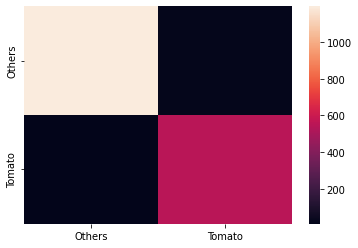

In [ ]:
# We print some metrics and the confusion matrix
# After the submission we realize that our values are really different from the ones we obtain on our validation/test set

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predicted_classes = np.argmax(predictions, axis=-1)
cm = (confusion_matrix(test_gen.classes, predicted_classes))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)



# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



In [ ]:
predicted_classes = np.argmax(predictions, axis=-1)
true_classes = test_gen.classes
ok = [0]*15
error = [0]*15
good = [0]*15

for i in range(0, 1775):

  if(predictions[i][1] > 0.5):
    if true_classes[i] == 1:
      ok[1] += 1
      if(predictions[i][1] > 0.4):
        good[1] += 1 
    else:
      error[1] += 1
  elif(predictions[i][0] > 0.5):
    if true_classes[i] == 0:
      ok[0] +=1
    else:
      error[0] += 1
print("ok:", ok)
print("error:", error)
print("good:", good)

ok: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
error: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
good: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1775
ok: [1194, 549, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
error: [22, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
good: [0, 549, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(1, 256, 256, 3)
(1, 256, 256, 3)


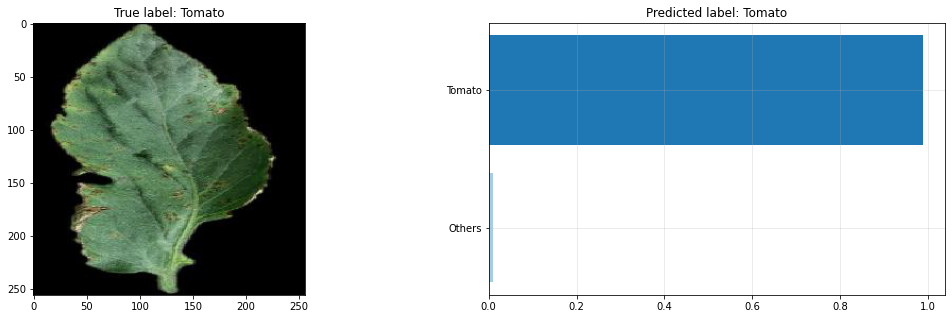

In [ ]:
batch = next(test_gen)
target = batch[1]
batch = batch[0]

# Get first image
image = batch[0] # batch size = 120
print(batch.shape)
target_label = labels[np.argmax(target[0])]

y = np.expand_dims(image, axis=0)
print(y.shape)
predictions = model.predict(y)
predictions.shape

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(image)
ax1.set_title('True label: '+target_label)
ax2.barh(labels, predictions[0], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[0])])
ax2.grid(alpha=.3)
plt.show()